# Final Experiments - Single-label SVM - CPU

## Utilities and Imports

In [2]:
%reload_ext autoreload
%autoreload 2

import itertools
from collections import Counter
import numpy as np
import pickle
from operator import itemgetter
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = [5, 10]

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from fastai import text as ft
from fastai import dataloader as fd
from fastai import dataset as fs
from fastai import learner as fl
from fastai import core as fc
from fastai import metrics as fm


from skai.runner import TextRunner, Adam_lambda
from skai.mwrapper import MWrapper, SKModel
from skai.utils import multi_to_text_out, vote_pred
from skai.utils import get_classification_type, weights_init, multilabel_prediction
from skai.dataset import TokenDataset, SimpleDataset


def mapt(f, *iters):
    return tuple(map(f, *iters))

def mapl(f, *iters):
    return list(map(f, *iters))

def manually_remove_problems(data):
    """ remove problem from data if it has a certain tag"""
    final_data = {}
    remove = ['*special']
    for i in data:
        if set(data[i][1][0]).intersection(set(remove)) == set():
            if data[i][0][0] != '':
                final_data[i] = data[i]
    return final_data

def get_single_label_problems(data):
    '''returns a dict of all problems which only have one label'''
    single_label_problems = {}
    for i in data:
        if len(data[i][1][0]) == 1:
            single_label_problems[i] = data[i]
    return single_label_problems

def get_classwise_distribution(data):
    class_count = {}
    for i in data:
        for cls in data[i][1][0]:
            if cls in class_count:
                class_count[cls] +=1 
            else:
                class_count[cls] = 1
    return class_count


def get_topk_single_label_problems(data,k):
    """ get top k by frequency single label problems"""
    class_dict = get_classwise_distribution(data)
    print(class_dict)
    class_dict = dict(sorted(class_dict.items(), key=itemgetter(1), reverse=True)[:k])
    print(set(class_dict.keys()))

    topk_data = {}
    for i in data:
        if set(data[i][1][0]).intersection(set(class_dict.keys())) != set():
            topk_data[i] = data[i]
            
    return topk_data

def make_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def make_multi_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def make_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][2])
    return Xtext, ytext

def make_non_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(f'{data[0][3]}\n{data[0][4]}\n{data[0][5]}')
    return Xtext, ytext

def get_class_list(labels):
    return list(set(labels))

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.gcf()
    fig.set_size_inches(22, 16)
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
#     plt.title(title, fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=32)
    plt.yticks(tick_marks, classes, fontsize=32)

    print(cm.max())
    fmt = '.2f' if normalize else 'd'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=32)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=32)
    plt.xlabel('Predicted label', fontsize=32)

/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load data

In [3]:
top5s = pickle.load(open('data/110_5single_26aug.pkl','rb'))
top10s = pickle.load(open('data/10single_26aug.pkl','rb'))

top5s, top10s = mapt(make_text_dataset, [top5s, top10s])

In [4]:
print(top5s[1][5])
print(len(top5s[0]))
print(Counter(top5s[1]).most_common())

dp
550
[('data structures', 110), ('implementation', 110), ('dp', 110), ('math', 110), ('greedy', 110)]


In [5]:
top5s[0][4]

"A. Water The Garden\ntime limit per test1 second\nmemory limit per test256 megabytes\ninputstandard input\noutputstandard output\nIt is winter now, and Max decided it's about time he watered the garden.\nThe garden can be represented as n consecutive garden beds, numbered from 1 to n. k beds contain water taps (i-th tap is located in the bed xi), which, if turned on, start delivering water to neighbouring beds. If the tap on the bed xi is turned on, then after one second has passed, the bed xi will be watered; after two seconds have passed, the beds from the segment [xi\u2009-\u20091,\u2009xi\u2009+\u20091] will be watered (if they exist); after j seconds have passed (j is an integer number), the beds from the segment [xi\u2009-\u2009(j\u2009-\u20091),\u2009xi\u2009+\u2009(j\u2009-\u20091)] will be watered (if they exist). Nothing changes during the seconds, so, for example, we can't say that the segment [xi\u2009-\u20092.5,\u2009xi\u2009+\u20092.5] will be watered after 2.5 seconds h

## SVM Definitions

In [6]:
svm_cv = SKModel(Pipeline(
    [('countvec', CountVectorizer(stop_words=stop_words)),
    ('clf', SVC())]),
    {'countvec__max_df': (0.25, 0.5, 0.75),
    'countvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__C": [0.01, 0.1, 1],
    "clf__class_weight": ['balanced', None],
    "clf__kernel": ['rbf', 'poly', 'linear']})  
svm_cv = MWrapper(svm_cv, 'svm_cv')

Note: Model directory for svm_cv exists.


In [7]:
svm_tf = SKModel(Pipeline(
    [('countvec', TfidfVectorizer(stop_words=stop_words)),
    ('clf', SVC())]),
    {'countvec__max_df': (0.25, 0.5, 0.75),
    'countvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__C": [0.01, 0.1, 1],
    "clf__class_weight": ['balanced', None],
    "clf__kernel": ['rbf', 'poly', 'linear']})  
svm_tf = MWrapper(svm_tf, 'svm_tf')

Note: Model directory for svm_tf exists.


## Experiments

### 5-class experiments

In [8]:
trunner = TextRunner([svm_cv, svm_tf], top5s[0], top5s[1], 'top5s', make_pyt_data=False)
Xall, yall = np.array(trunner.rdata), np.array(trunner.labels)

Checkpoint reached: raw data cleaned.
multiclass classification.


In [9]:
runs = 1
out_dim = 5

preds_txt_cv, preds_txt_tf = [], []
targs_txt = []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+42)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        print(f'Outer split no. {j}')
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        cv_clf, cv_score = trunner.get_clf_sk(svm_cv, X_train, y_train)
        tf_clf, tf_score = trunner.get_clf_sk(svm_tf, X_train, y_train)
        
        preds = cv_clf.predict(X_test)
        preds_txt_cv.append(preds)
        
        preds = tf_clf.predict(X_test)
        preds_txt_tf.append(preds)
        
        targs_txt.append(y_test)
       
        print(accuracy_score(np.concatenate(targs_txt),
                             np.concatenate(preds_txt_cv)))

preds_txt_cv = np.concatenate(preds_txt_cv)
preds_txt_tf = np.concatenate(preds_txt_tf)
targs_txt = np.concatenate(targs_txt)

Outer split no. 0
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   26.9s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.1min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   33.8s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.5min finished


0.5454545454545454
Outer split no. 1
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   26.8s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.1min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   34.6s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.5min finished


0.509090909090909
Outer split no. 2
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   26.9s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.1min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   34.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.5min finished


0.4909090909090909
Outer split no. 3
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   26.7s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.1min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   35.6s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.5min finished


0.4818181818181818
Outer split no. 4
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   27.0s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.2min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   33.7s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.5min finished


0.48727272727272725
Outer split no. 5
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   27.4s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.2min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   35.0s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.5min finished


0.49393939393939396
Outer split no. 6
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   26.9s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.2min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   35.7s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.5min finished


0.4909090909090909
Outer split no. 7
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   26.9s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.2min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   34.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.5min finished


0.49318181818181817
Outer split no. 8
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   27.4s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.2min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   34.2s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.5min finished


0.4888888888888889
Outer split no. 9
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   28.4s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.2min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   34.7s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  1.4min finished


0.49272727272727274


In [8]:
# pickle.dump([preds_txt_cv, preds_txt_tf, targs_txt], open('data/results/svm_5s.pkl', 'wb'))
preds_txt_cv, preds_txt_tf, targs_txt = pickle.load(open('data/results/svm_5s.pkl', 'rb'))

                 precision    recall  f1-score   support

data structures       0.77      0.64      0.70       110
             dp       0.38      0.40      0.39       110
         greedy       0.43      0.36      0.40       110
 implementation       0.42      0.40      0.41       110
           math       0.49      0.66      0.57       110

    avg / total       0.50      0.49      0.49       550

0.49272727272727274
0.49215491082921514
Normalized confusion matrix
[[0.63636 0.11818 0.09091 0.05455 0.1    ]
 [0.05455 0.4     0.20909 0.16364 0.17273]
 [0.04545 0.22727 0.36364 0.19091 0.17273]
 [0.04545 0.20909 0.10909 0.4     0.23636]
 [0.04545 0.09091 0.06364 0.13636 0.66364]]
0.6636363636363637


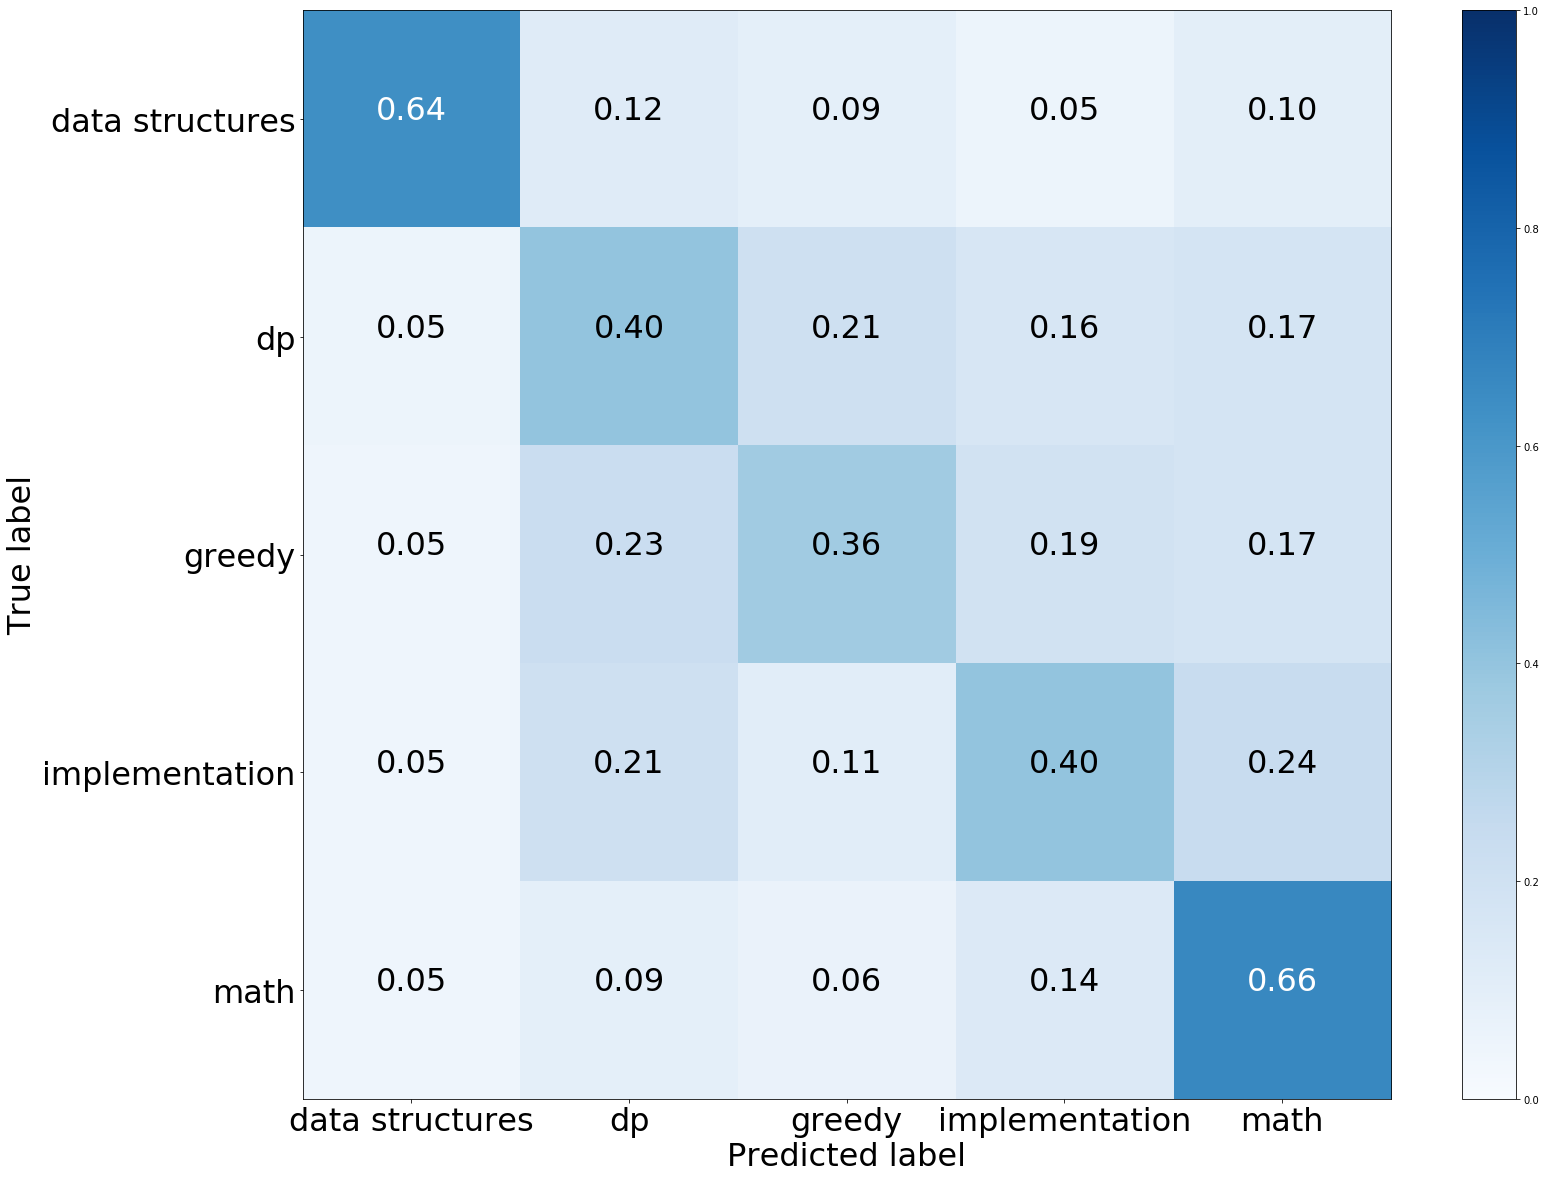

In [11]:
labels = ['data structures', 'dp', 'greedy', 'implementation', 'math']

print(classification_report(targs_txt, preds_txt_cv, labels=labels))
print(accuracy_score(targs_txt, preds_txt_cv))
print(f1_score(targs_txt, preds_txt_cv, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt_cv, labels)

                 precision    recall  f1-score   support

data structures       0.71      0.70      0.70       110
             dp       0.36      0.41      0.38       110
         greedy       0.40      0.44      0.42       110
 implementation       0.41      0.35      0.37       110
           math       0.53      0.50      0.52       110

    avg / total       0.48      0.48      0.48       550

0.4781818181818182
0.47884246171351896
Normalized confusion matrix
[[0.7     0.10909 0.07273 0.05455 0.06364]
 [0.07273 0.40909 0.22727 0.12727 0.16364]
 [0.06364 0.2     0.43636 0.2     0.1    ]
 [0.08182 0.20909 0.25455 0.34545 0.10909]
 [0.07273 0.2     0.10909 0.11818 0.5    ]]
0.7


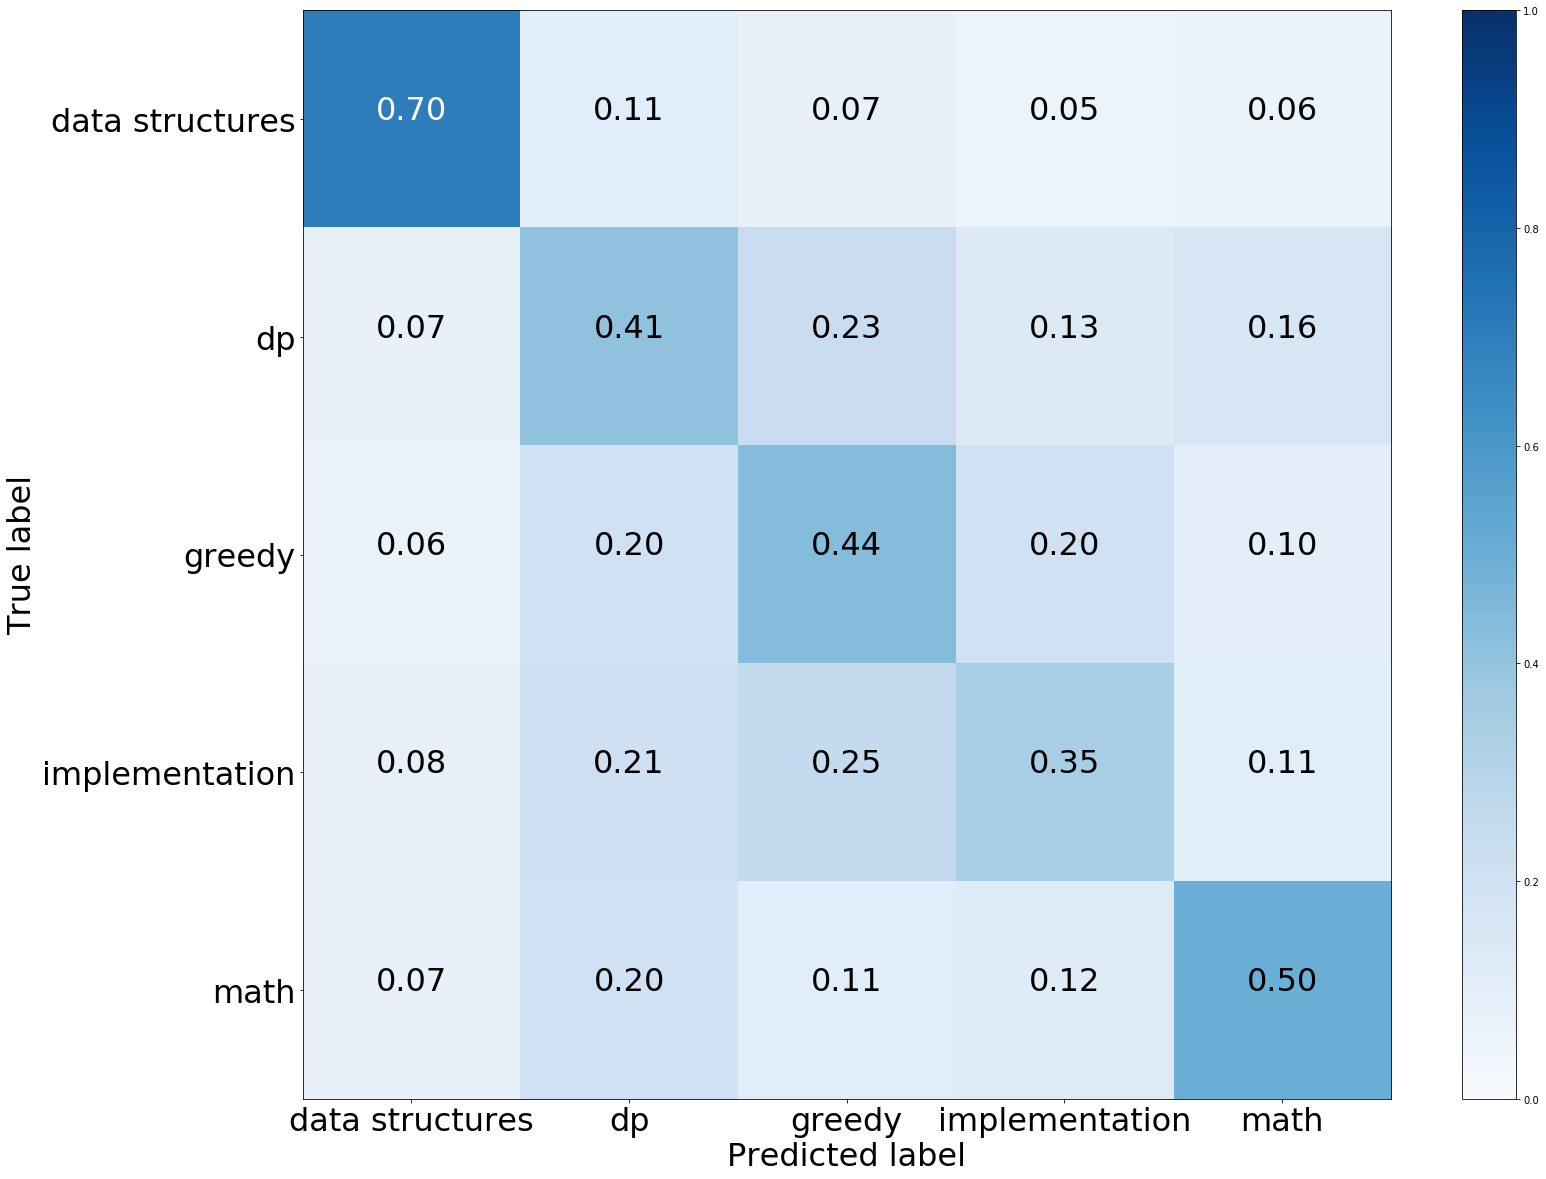

In [12]:
labels = ['data structures', 'dp', 'greedy', 'implementation', 'math']

print(classification_report(targs_txt, preds_txt_tf, labels=labels))
print(accuracy_score(targs_txt, preds_txt_tf))
print(f1_score(targs_txt, preds_txt_tf, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt_tf, labels)

### 10-class experiments

In [9]:
trunner = TextRunner([svm_cv, svm_tf], top10s[0], top10s[1], 'top10s', make_pyt_data=False)
Xall, yall = np.array(trunner.rdata), np.array(trunner.labels)

Checkpoint reached: raw data cleaned.
multiclass classification.


In [14]:
runs = 1
out_dim = 10

preds_txt_cv, preds_txt_tf = [], []
targs_txt = []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+42)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        print(f'Outer split no. {j}')
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        cv_clf, cv_score = trunner.get_clf_sk(svm_cv, X_train, y_train)
        tf_clf, tf_score = trunner.get_clf_sk(svm_tf, X_train, y_train)
        
        preds = cv_clf.predict(X_test)
        preds_txt_cv.append(preds)
        
        preds = tf_clf.predict(X_test)
        preds_txt_tf.append(preds)
        
        targs_txt.append(y_test)

        print(accuracy_score(np.concatenate(targs_txt),
                             np.concatenate(preds_txt_cv)))

preds_txt_cv = np.concatenate(preds_txt_cv)
preds_txt_tf = np.concatenate(preds_txt_tf)
targs_txt = np.concatenate(targs_txt)

Outer split no. 0
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   22.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.8min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.2min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   24.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.4min finished


0.4396551724137931
Outer split no. 1
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   21.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.6min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.0min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   23.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.3min finished


0.4525862068965517
Outer split no. 2
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   23.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.0min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   26.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.6min finished


0.46551724137931033
Outer split no. 3
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   23.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.3min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   25.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.7min finished


0.46336206896551724
Outer split no. 4
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   23.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.4min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   23.9s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.4min finished


0.45689655172413796
Outer split no. 5
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   23.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.1min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   24.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.5min finished


0.4583333333333333
Outer split no. 6
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   23.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.8min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.2min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   25.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.5min finished


0.4667487684729064
Outer split no. 7
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   24.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.8min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.2min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   24.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.4min finished


0.46551724137931033
Outer split no. 8
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   22.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.8min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.1min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   24.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.4min finished


0.47413793103448276
Outer split no. 9
Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   22.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.1min finished


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   25.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 486 out of 486 | elapsed:  4.3min finished


0.47886108714408976


In [17]:
# pickle.dump([preds_txt_cv, preds_txt_tf, targs_txt], open('data/results/svm_10s.pkl', 'wb'))
preds_txt_cv, preds_txt_tf, targs_txt = pickle.load(open('data/results/svm_10s.pkl', 'rb'))

                         precision    recall  f1-score   support

            brute force       0.12      0.02      0.03        65
constructive algorithms       0.20      0.06      0.10        64
        data structures       0.66      0.54      0.59       110
                     dp       0.40      0.30      0.34       144
        dfs and similar       0.38      0.08      0.14        36
               geometry       0.60      0.51      0.55        49
                 greedy       0.28      0.17      0.22       121
         implementation       0.50      0.83      0.63       405
                   math       0.47      0.42      0.44       132
                strings       0.32      0.21      0.25        33

            avg / total       0.44      0.48      0.43      1159

0.47886108714408976
0.4318393739323627
Normalized confusion matrix
[[0.01538 0.01538 0.04615 0.12308 0.      0.      0.09231 0.58462 0.12308 0.     ]
 [0.      0.0625  0.03125 0.03125 0.03125 0.04688 0.07812 0.625   0

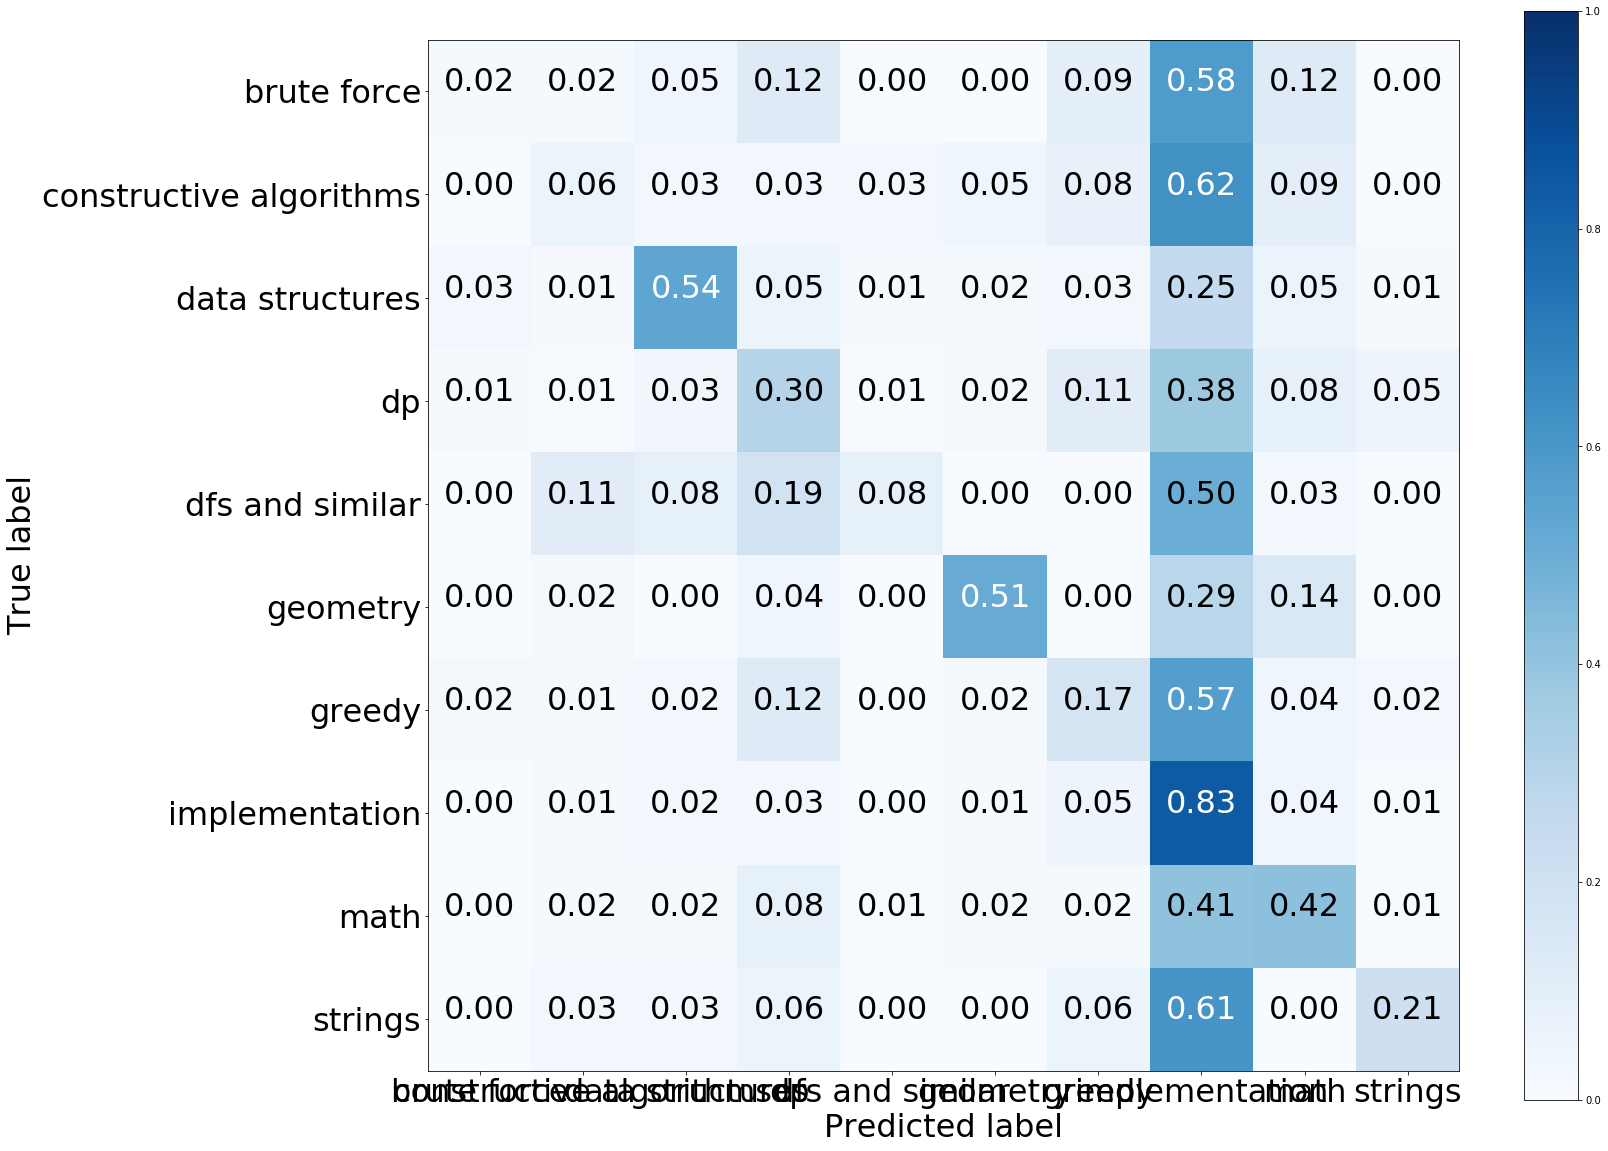

In [19]:
labels = ['brute force', 'constructive algorithms', 'data structures',
          'dp', 'dfs and similar', 'geometry', 'greedy',
          'implementation', 'math', 'strings']

print(classification_report(targs_txt, preds_txt_cv, labels=labels))
print(accuracy_score(targs_txt, preds_txt_cv))
print(f1_score(targs_txt, preds_txt_cv, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt_cv, labels)

                         precision    recall  f1-score   support

            brute force       0.08      0.02      0.03        65
constructive algorithms       0.12      0.03      0.05        64
        data structures       0.57      0.50      0.53       110
                     dp       0.41      0.22      0.29       144
        dfs and similar       0.18      0.06      0.09        36
               geometry       0.67      0.63      0.65        49
                 greedy       0.22      0.17      0.19       121
         implementation       0.48      0.81      0.60       405
                   math       0.53      0.36      0.43       132
                strings       0.31      0.30      0.31        33

            avg / total       0.41      0.46      0.41      1159

0.457290767903365
0.4086365512340247
Normalized confusion matrix
[[0.01538 0.      0.04615 0.04615 0.01538 0.      0.12308 0.64615 0.09231 0.01538]
 [0.03125 0.03125 0.14062 0.01562 0.04688 0.03125 0.15625 0.5     0.0

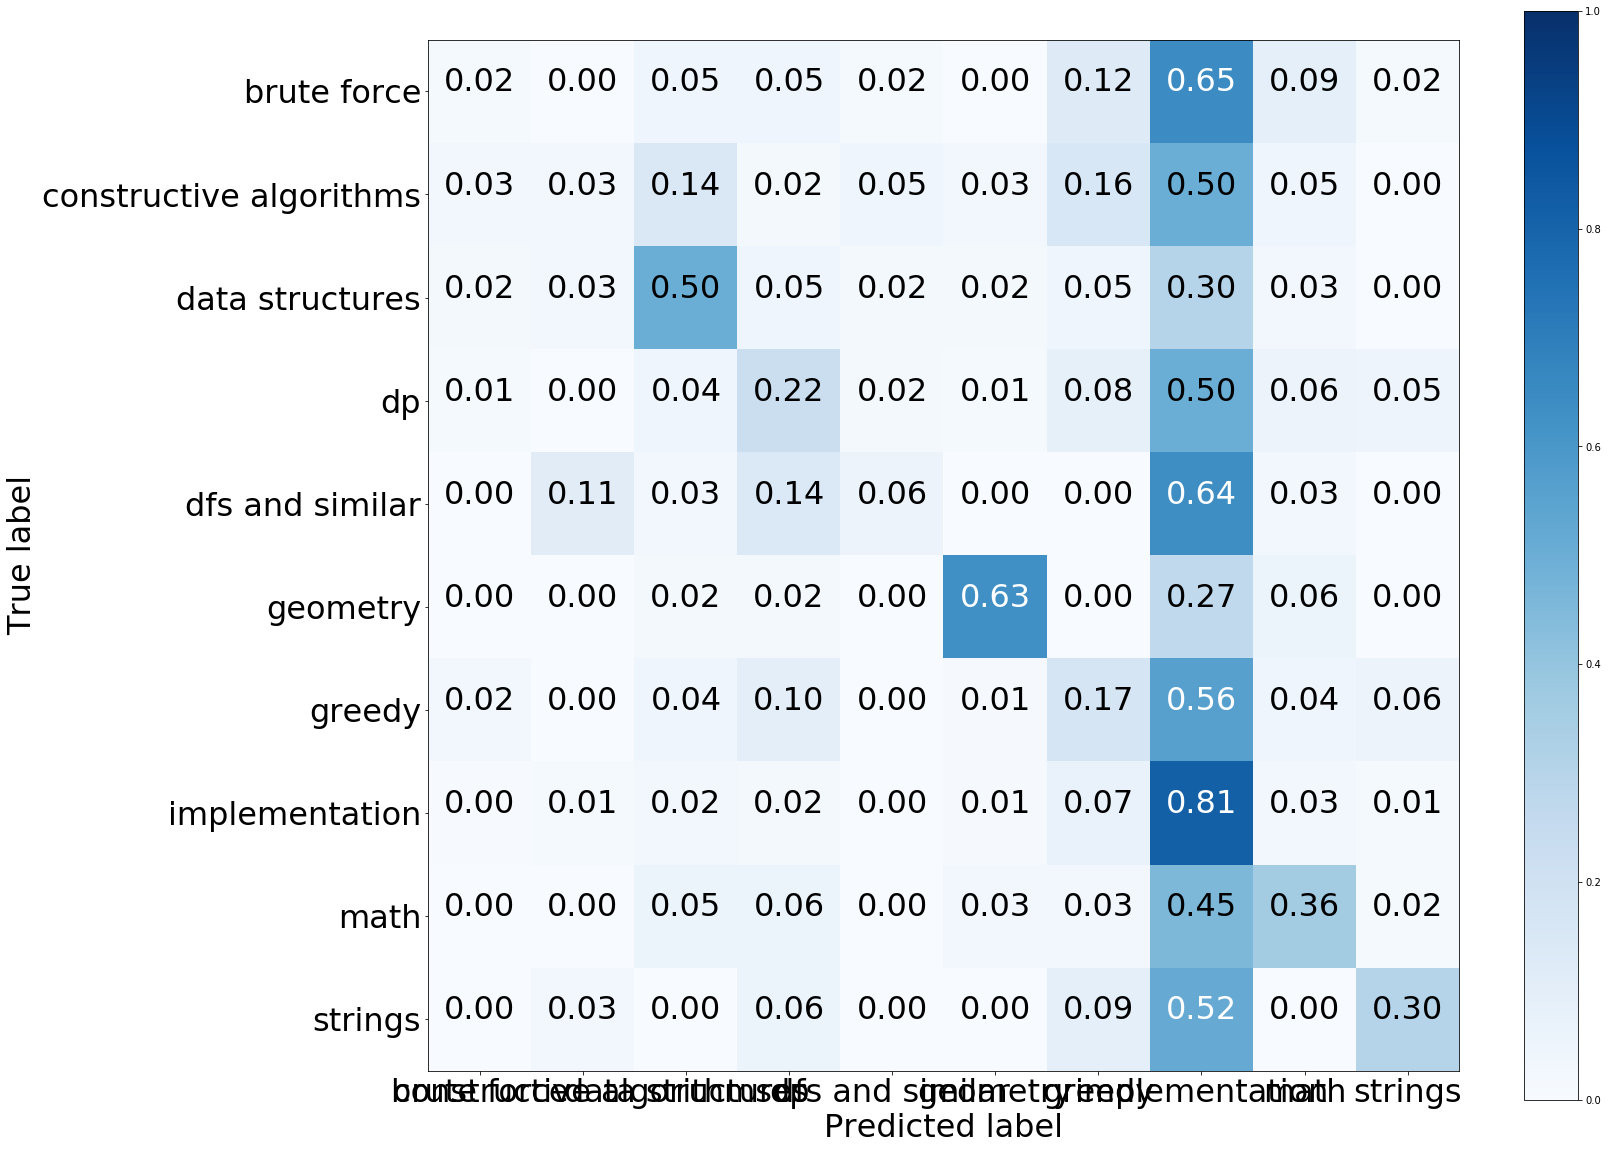

In [20]:
labels = ['brute force', 'constructive algorithms', 'data structures',
          'dp', 'dfs and similar', 'geometry', 'greedy',
          'implementation', 'math', 'strings']

print(classification_report(targs_txt, preds_txt_tf, labels=labels))
print(accuracy_score(targs_txt, preds_txt_tf))
print(f1_score(targs_txt, preds_txt_tf, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt_tf, labels)